In [1]:
# Load images and labels
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

# # Define the input directory
input_dir = 'C:/Users/odys_/Desktop/ML_winows_2/archive_small'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each folder (class name) in the input directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpeg') or file_name.endswith('.png'):  # Check for valid image files
                img_path = os.path.join(category_path, file_name)
                try:
                    # Open and preprocess the image
                    img = Image.open(img_path)
                    # img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img)
                    
                    # Append the image and its label
                    images.append(img_array)
                    labels.append(category)  # Use the folder name as the label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print some information about the loaded data
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 600 images.
Image shape: (64, 64) 
Labels: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']


In [2]:
from sklearn.model_selection import train_test_split

# Set random_state for reproducibility
random_state = 42

# Split into train and test only
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=random_state, stratify=labels
)

print(f"Shape Train set: {X_train.shape}, labels: {y_train.shape}")
print(f"Shape Test set: {X_test.shape}, labels:{y_test.shape}")

Shape Train set: (420, 64, 64), labels: (420,)
Shape Test set: (180, 64, 64), labels:(180,)


In [3]:
# --- Preprocessing: Normalize images and encode labels ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalize pixel values
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Encode labels to integers, then to one-hot
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

print(f"Classes: {le.classes_}")
print(f"y_train_cat shape: {y_train_cat.shape}")

Classes: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']
y_train_cat shape: (420, 4)


In [4]:
# --- Build the CNN model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Expand dims for grayscale images
if len(X_train_norm.shape) == 3:
    X_train_norm = np.expand_dims(X_train_norm, -1)
    X_test_norm = np.expand_dims(X_test_norm, -1)

input_shape = X_train_norm.shape[1:]  # Now should be (64, 64, 1)
num_classes = y_train_cat.shape[1]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\odys_\Desktop\ML_winows_2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,092 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- Train the model ---
history = model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.5297 - loss: 0.9984 - val_accuracy: 0.9524 - val_loss: 0.1189
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.9618 - loss: 0.1075 - val_accuracy: 0.9524 - val_loss: 0.0868
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.9606 - loss: 0.1283 - val_accuracy: 1.0000 - val_loss: 0.0289
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.9863 - loss: 0.0495 - val_accuracy: 0.9881 - val_loss: 0.0296
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.9877 - loss: 0.0317 - val_accuracy: 0.9881 - val_loss: 0.0229
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.9954 - loss: 0.0093 - val_accuracy: 0.9881 - val_loss: 0.0194
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.9978 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.9967 - loss: 0.0174 - val_accuracy: 1.0000 - val_

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9831 - loss: 0.0470
Test accuracy: 0.989


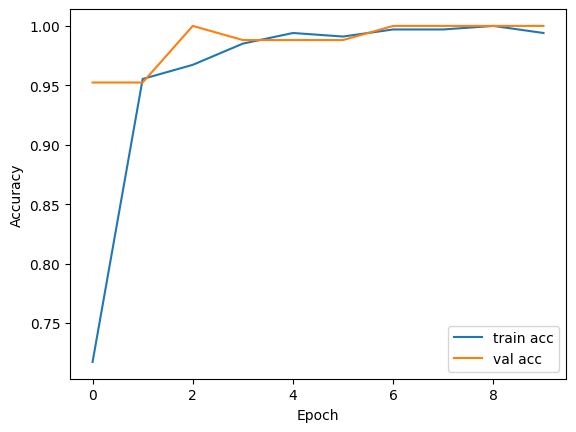

In [6]:
# --- Evaluate the model ---
test_loss, test_acc = model.evaluate(X_test_norm, y_test_cat)
print(f"Test accuracy: {test_acc:.3f}")

# Optional: Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


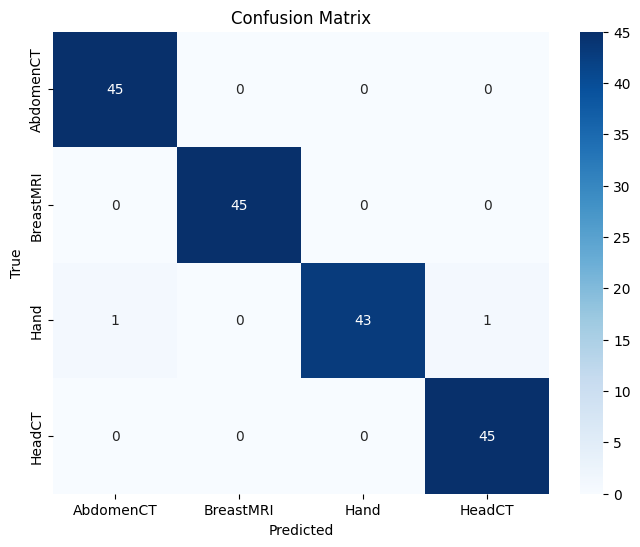

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       0.98      1.00      0.99        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.96      0.98        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



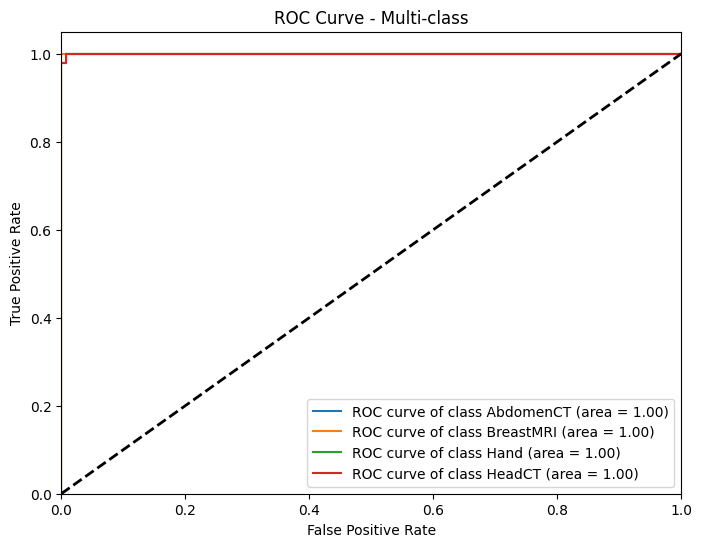

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Predict class probabilities and convert to class labels
y_pred_probs = model.predict(X_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# ROC Curve for each class
y_test_bin = label_binarize(y_true, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()

In [8]:
# --- Hyperparameter tuning with Keras Tuner ---
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning'
)

tuner.search(
    X_train_norm, y_train_cat,
    epochs=5,
    validation_split=0.2,
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in best_hp.values.keys():
    print(f"{param}: {best_hp.get(param)}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Trial 5 Complete [00h 00m 27s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 50s
Best hyperparameters:
conv_1_filters: 48
conv_2_filters: 32
dense_units: 128
dropout: 0.5
learning_rate: 0.01
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.3548 - loss: 3.2284 - val_accuracy: 0.7262 - val_loss: 0.7554
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.7529 - loss: 0.7513 - val_accuracy: 0.9881 - val_loss: 0.4172
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.9703 - loss: 0.4282 - val_accuracy: 0.9881 - val_loss: 0.1704
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.9763 - loss: 0.2427 - val_accuracy: 0.9881 - val_loss: 0.0843
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.9694 - loss: 0.1397 - val_accuracy: 0.9881 - val_loss: 0.1134
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.9943 - loss: 0.0793 - val_accuracy: 0.9881 - val_loss: 0.0816
Epoch 7/10